In [5]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy
from multiprocessing import Pool, shared_memory

mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"

from common_func import *

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [6]:
def out2gyr(outs):
    global snaps
    table = snaps.iout_avail
    gyrs = np.zeros(len(outs))
    for i, iout in enumerate(outs):
        gyrs[i] = table[table['iout']==iout][0]['age']
    return gyrs

In [7]:
LG = pklload(f"{database}/LG")
allsubs = None
states = None
for key in LG.keys():
    subs = LG[key]['subs']
    real = LG[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs = subs if allsubs is None else np.hstack((allsubs, subs))
    states = state if states is None else np.hstack((states, state))
argsort = np.argsort(allsubs['id'])
allsubs = allsubs[argsort]
states = states[argsort]

# Tree

In [8]:
tree = pklload(f"{database}/02_main_progenitors.pickle")
tree.shape, tree.dtype, tree[0]

((3281052,),
 dtype([('lastid', '<i2'), ('timestep', '<i2'), ('id', '<i2'), ('give_score', '<f8'), ('take_score', '<f8')]),
 (589, 1026, 589, 1., 1.))

In [9]:
fnames = os.listdir(f"{database}/main_prog")
fnames = [fname for fname in fnames if(fname.startswith('subhalos'))]
fnames.sort(reverse=True)

In [10]:
tmp = pklload(f"{database}/main_prog/{fnames[0]}")[0]
trees = np.empty(tmp.shape[0]*len(fnames), dtype=tmp.dtype)
cursor = 0
uri.timer.verbose=0
for fname in tqdm( fnames ):
    tmp = pklload(f"{database}/main_prog/{fname}")[0]
    trees[cursor : cursor+len(tmp)] = tmp
    cursor += len(tmp)
trees.shape

  0%|          | 0/849 [00:00<?, ?it/s]

(3269499,)

In [11]:
colors = {'dink':'red', 'pair':'blue', 'upair':'green'}
scolors = {'dink':'salmon', 'pair':'lightskyblue', 'upair':'yellowgreen'}
zorders = {'dink':0, 'pair':2, 'upair':1}

# Score Cut

## Check low length

I want to define the threshold that decides which are real progenitors

22177 846 pair
0.004291845493562232 0.00125


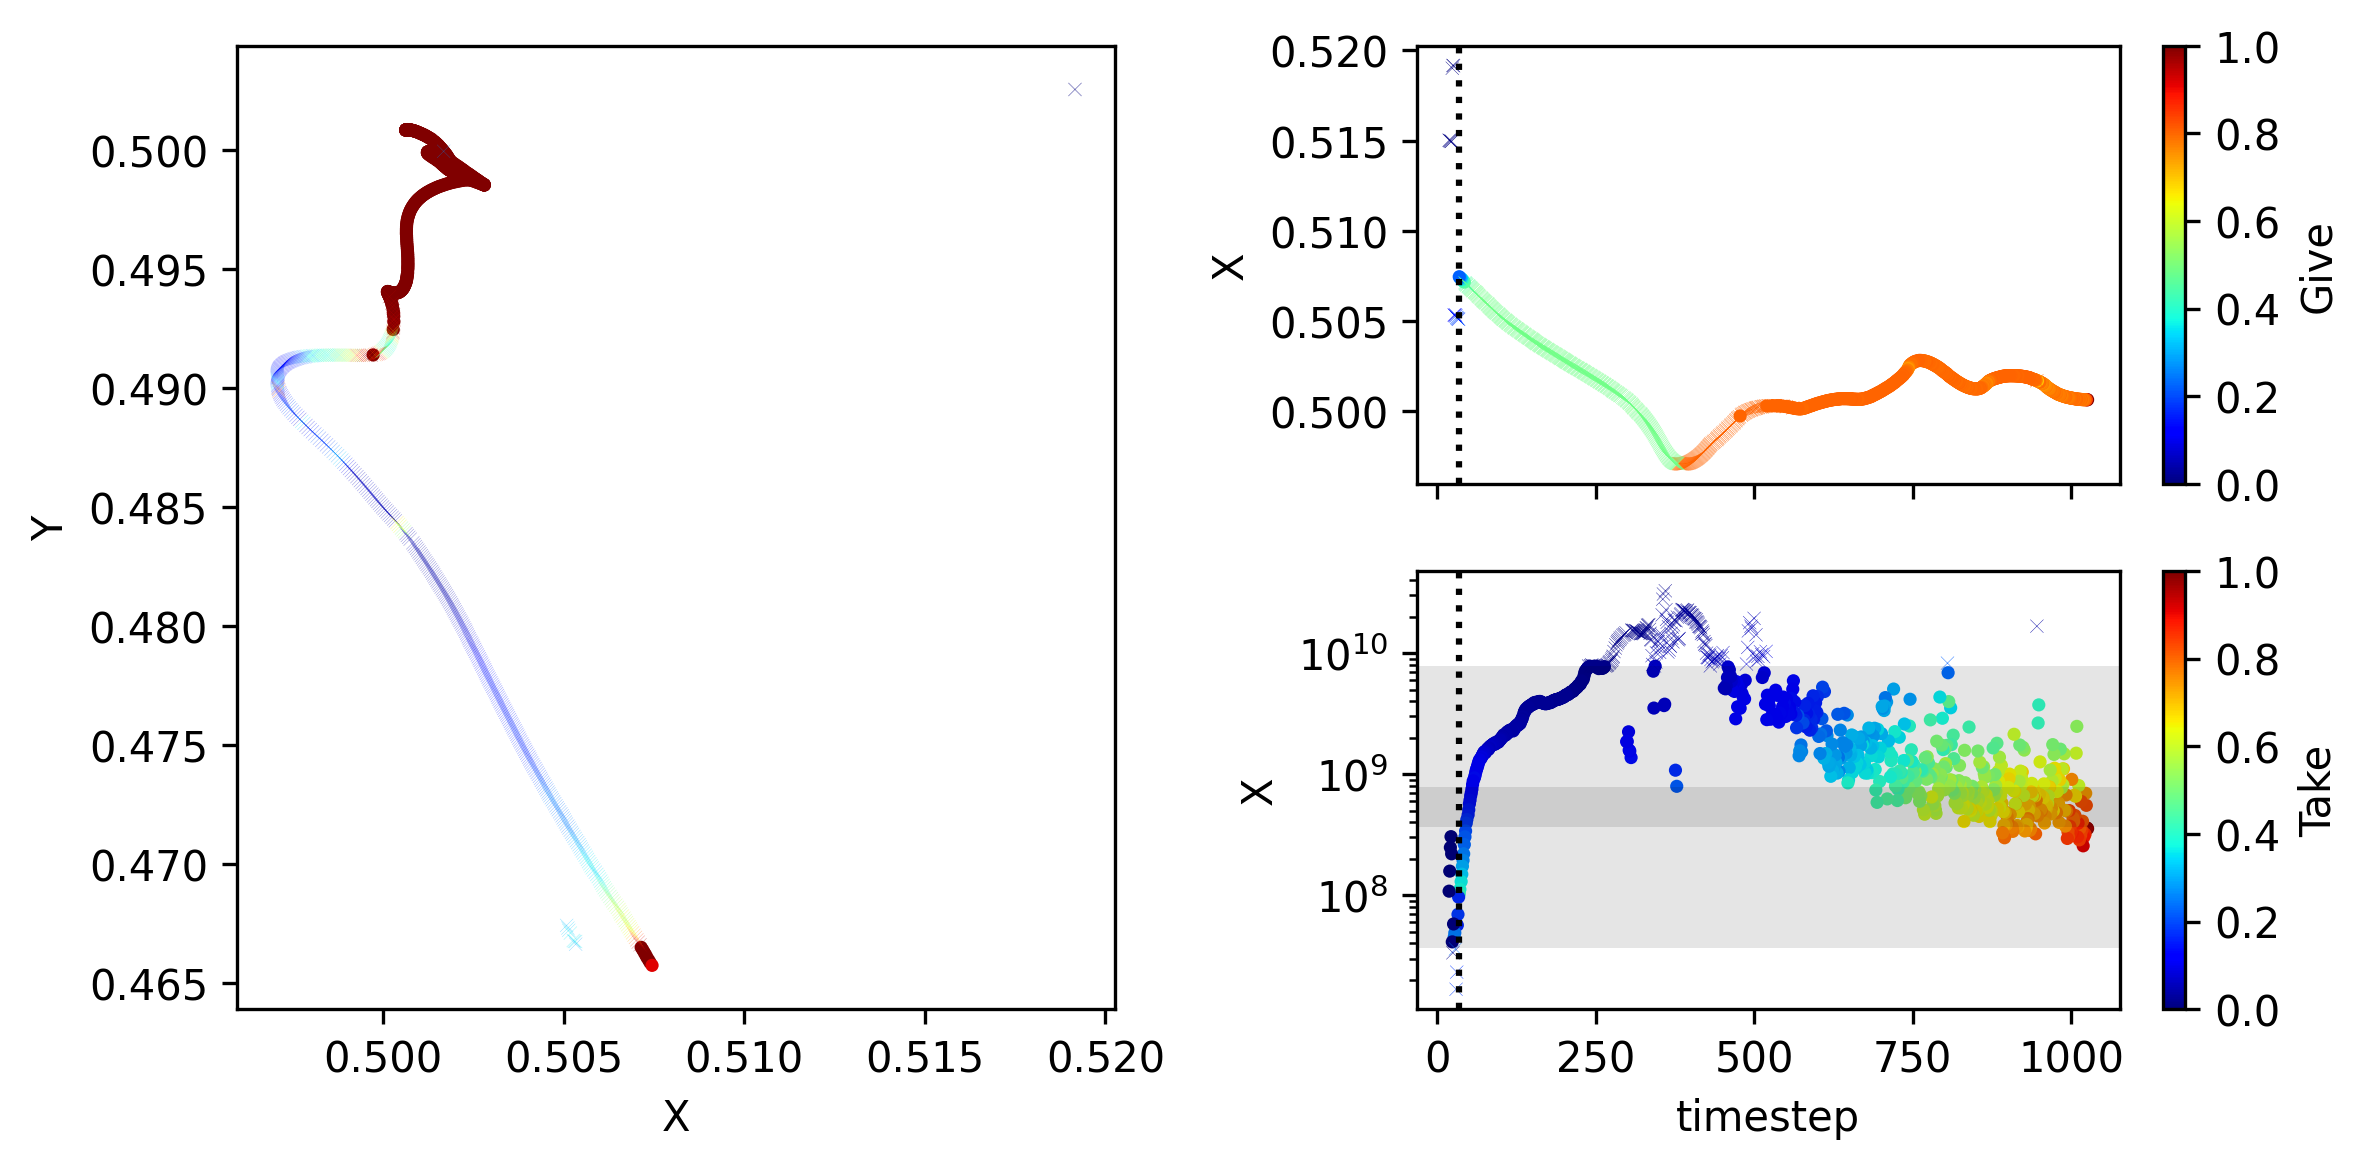

In [12]:
where = np.arange(len(allsubs))
length=10000
while(length>500):
    state='dink'
    while(state=='dink'):
        random = np.random.choice(where)
        target = allsubs[random]
        state = states[random]
    # print(states[where])

    branch = trees[trees['lastid'] == target['id']]
    branch = branch[branch['take_score']>0]
    score = branch['give_score']*branch['take_score']
    umask = (score > 0.1) | ((branch['give_score']+branch['take_score']) > 1.1) | (branch['take_score'] > 0.4)
    length = np.sum(umask)

val = 'mdm_vir'
# log = False
log = True
top20per = np.argsort(branch['take_score'])[-int(len(branch)/5):]
m16,m50,m84 = np.percentile(branch['mdm_vir'][top20per], q=[16,50,84])
if(log):
    lower = m16/10; upper = m84*10
else:
    lower = m16 - (m50-m16); upper = m84 + (m84+50)
if(lower > branch[0]['mdm_vir']): lower = branch[0]['mdm_vir']
if(upper < branch[0]['mdm_vir']): upper = branch[0]['mdm_vir']

mmask = (branch[val] < upper)&(branch[val] > lower)
print(target['id'],len(branch), state)

fig = plt.figure(tight_layout=True, dpi=300, figsize=(8,4))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[:, 0])

print(np.min(branch['give_score']), np.min(branch['take_score']))
first = np.min(branch[umask]['timestep'])
tmask = branch['timestep'] >= (first-10)
sc = ax.scatter(branch[umask & tmask]['x'], branch[umask & tmask]['y'], c=score[umask & tmask], ec='none', cmap=plt.cm.jet, vmin=0, vmax=0.1, s=10)
ax.scatter(branch[~umask & tmask]['x'], branch[~umask & tmask]['y'], c=score[~umask & tmask], marker='x', cmap=plt.cm.jet, vmin=0, vmax=0.1, s=10, lw=0.1, alpha=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax = fig.add_subplot(gs[0, 1])
ax.set_xticklabels([])
score = branch['give_score']#*branch['take_score']
# mask = score > 0.2
sc = ax.scatter(branch[umask]['timestep'], branch[umask]['x'], c=score[umask], ec='none', cmap=plt.cm.jet, vmin=0, vmax=1, s=10)
ax.scatter(branch[~umask]['timestep'], branch[~umask]['x'], c=score[~umask], marker='x', cmap=plt.cm.jet, vmin=0, vmax=1, s=10, lw=0.1)
ax.set_ylabel("X")
ax.axvline(first, c='k',ls=':')
fig.colorbar(sc, ax=ax, label='Give')

ax = fig.add_subplot(gs[1, 1])#, sharex=ax)
score = branch['take_score']#*branch['take_score']
# mask = score > 0.1
sc = ax.scatter(branch[mmask]['timestep'], branch[mmask][val], c=score[mmask], ec='none', cmap=plt.cm.jet, vmin=0, vmax=1, s=10)
ax.scatter(branch[~mmask]['timestep'], branch[~mmask][val], c=score[~mmask], marker='x', cmap=plt.cm.jet, vmin=0, vmax=1, s=10, lw=0.1)
ax.axhspan(m16, m84, fc='k', alpha=0.1, ec='none')
ax.axhspan(lower, upper, fc='k', alpha=0.1, ec='none')
ax.set_xlabel("timestep")
ax.set_ylabel("X")
if(log): ax.set_yscale('log')
ax.axvline(first, c='k',ls=':')
fig.colorbar(sc, ax=ax, label='Take')


plt.subplots_adjust(hspace=0)

Conclusion:  
- Find first timestep that satisfies :(score > 0.1) | ((branch['give_score']+branch['take_score']) > 1.1) | (branch['take_score'] > 0.4)  
- Discard snapshots before that time
- choose top20% in take score samples, and find m16, m84
- within m16/10 ~ m84*10

## Tree length

  0%|          | 0/3171 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

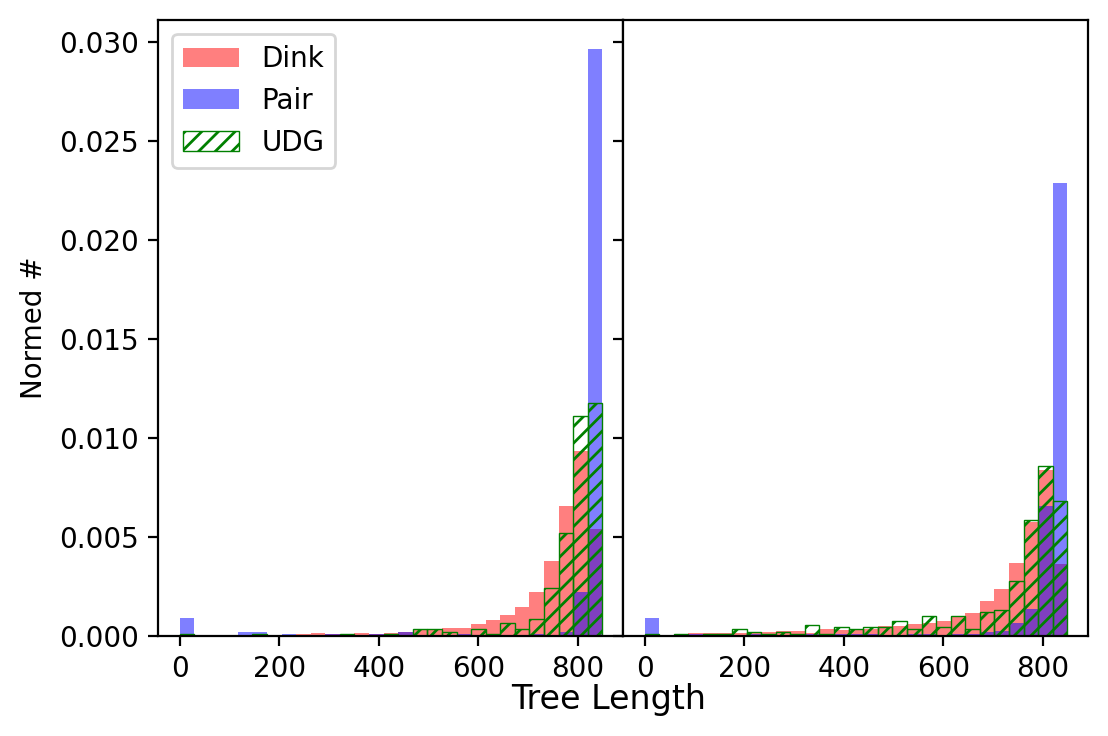

In [13]:
dinks = allsubs[states == 'dink']
pairs = allsubs[states == 'pair']
upairs = allsubs[states == 'upair']
nout = np.unique(trees['timestep'])

lleng = np.zeros(len(allsubs), dtype=int)
sleng = np.zeros(len(allsubs), dtype=int)

fig, axes = plt.subplots(ncols=2, figsize=(6,4), dpi=200, sharey=True)
names = ['dink', 'pair', 'upair']
labels = ['Dink','Pair','UDG']

reduced_tree = {}
for name,label in zip(names, labels):
    samples = allsubs[states == name]
    llengs = np.zeros(len(samples), dtype=np.int32)
    slengs = np.zeros(len(samples), dtype=np.int32)
    for i,sub in tqdm( enumerate(samples), total=len(samples) ):
        arg = np.where(allsubs['id']==sub['id'])[0][0]
        branch = trees[arg::len(allsubs)]#[trees['lastid'] == target['id']]
        branch = branch[branch['take_score']>0]
        score = branch['give_score']*branch['take_score']


        mask = (score > 0.1) | ((branch['give_score']+branch['take_score']) > 1.1) | (branch['take_score'] > 0.4)       
        first = np.min(branch[mask]['timestep'])
        cbranch = branch[branch['timestep'] >= first]
        top20per = top20per = np.argsort(branch['take_score'])[-int(len(branch)/5):]
        if(len(top20per)>10):
            m16,m50,m84 = np.percentile(branch['mdm_vir'][top20per], q=[16,50,84])
            lower = m16/10; upper = m84*10
            if(lower > branch[0]['mdm_vir']): lower = branch[0]['mdm_vir']
            if(upper < branch[0]['mdm_vir']): upper = branch[0]['mdm_vir']
        else:
            lower = branch[0]['mdm_vir']/10; upper = branch[0]['mdm_vir']*10

        llengs[i] = len(cbranch); lleng[arg] = len(cbranch)
        mbranch = cbranch[(cbranch['mdm_vir'] <= upper)&(cbranch['mdm_vir'] >= lower)]
        slengs[i] = len(mbranch); sleng[arg] = len(mbranch)
        
        reduced_tree[sub['id']] = mbranch

    if(name=='upair'):
        axes[0].hist(llengs, fc='none',ec=colors[name], density=True, bins=np.linspace(0,len(nout),30), hatch='////', label=label, lw=0.5)
        axes[1].hist(slengs, fc='none',ec=colors[name], density=True, bins=np.linspace(0,len(nout),30), hatch='////', label=label, lw=0.5)
    else:
        axes[0].hist(llengs, alpha=0.5, color=colors[name], density=True, bins=np.linspace(0,len(nout),30), label=label)
        axes[1].hist(slengs, alpha=0.5, color=colors[name], density=True, bins=np.linspace(0,len(nout),30), label=label)
axes[0].legend()
plt.subplots_adjust(wspace=0)
axes[0].set_ylabel("Normed #")
fig.supxlabel("Tree Length")

pklsave(reduced_tree,f"{database}/06_reduced_tree.pickle", overwrite=True)

# 2D Orbits
See `06_mass_evolution.py`
- `f"{database}/photo/06_evolution/nh_{key:04d}_2dorbit.png"`

In [14]:
minmax(np.log10(allsubs['m']))
minmax(np.log10(allsubs['mvir']))
minmax(np.log10(allsubs['mdm_vir']))
minmax(np.log10(allsubs['mstar_vir']))
minmax(np.log10(allsubs['mcell_vir']))
minmax(np.log10(allsubs['mcold_vir']))

len3851: min=8.115680503198076, mean=8.701653601588076, max=11.930781195355392
len3851: min=6.59280175791774, mean=8.605588179080675, max=11.787185653114586
len3851: min=6.808165770633231, mean=8.714014509940352, max=11.917356755331697
len3851: min=-inf, mean=-inf, max=10.730742233173629
len3851: min=-inf, mean=-inf, max=10.832976903562662
len3851: min=-inf, mean=-inf, max=10.50117173108526


/tmp/ipykernel_1310/1091277345.py:4: RuntimeWarning: divide by zero encountered in log10
  minmax(np.log10(allsubs['mstar_vir']))
/tmp/ipykernel_1310/1091277345.py:5: RuntimeWarning: divide by zero encountered in log10
  minmax(np.log10(allsubs['mcell_vir']))
/tmp/ipykernel_1310/1091277345.py:6: RuntimeWarning: divide by zero encountered in log10
  minmax(np.log10(allsubs['mcold_vir']))


# Final DM Mass Binning

## Mass Evolution

In [15]:
##### Change These #####
binval = 'mvir' 
binname = fr"$M_{{DM,vir,z=0}}$"
mmin=7.5; mmax=11.5
mbins = np.arange(mmin, mmax, 0.5)

vals = ['mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', ('mstar_vir','mcell_vir')]
valnames = [fr"$M_{{DM,vir,z}}$", fr"$M_{{*,vir,z}}$", fr"$M_{{Gas,vir,z}}$", fr"$M_{{Cold,vir,z}}$", fr"$M_{{Bary,vir,z}}$"]
titles = ["DM Mass Evolution", "Stellar Mass Evolution", "Gas Mass Evolution", "Cold Gas Mass Evolution", "Baryon Mass Evolution"]
fnames = ['dm', 'star', 'gas', 'cold', 'baryon']
ymins = [1e6 + 1, 1e4 + 1, 1e5 + 1, 1e4 + 1, 1e5 + 1]
########################

def getval(table, args):
    y = 0
    if(type(args) is str): return table[args]
    elif(type(args) is tuple):
        for arg in args:
            y += table[arg]
        return y
    else:
        raise ValueError("args must be str or tuple")



for val,valname,title,ymin,fname in zip(vals,valnames,titles,ymins,fnames):
    if(os.path.exists(f"{database}/photo/06_evolution/Massevol_{fname}_finalbin_gyr.png")): continue
    fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
    plt.subplots_adjust(wspace=0, hspace=0)
    for ax in axes.flatten():
        ax.set_yscale('log')



    results = {}
    for iax in range(8):
        results[iax] = {}
        for name in names:
            results[iax][name] = np.zeros(1027)
    for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
        if(sub[binval] < 10**7.5): continue
        iax = np.searchsorted(mbins, np.log10(sub[binval]))-1
        ax = axes.flatten()[iax]
        color = scolors[state]
        tmp = reduced_tree[sub['id']]
        tmp = tmp[tmp['take_score'] > 0.1]
        zorder = zorders[state]
        y = getval(tmp, val)
        ax.scatter(out2gyr(tmp['timestep']), y, ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)
        # ax.plot(tmp['timestep'], y, color=color, lw=0.25, alpha=1, zorder=zorder)

        results[iax][state][tmp['timestep']] += y
        results[iax][state][0] += 1

    # label1s = [fr"{binname}=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"{binname}>$10^{{11}}\,M_\odot$"]
    labels = [fr"=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"=$10^{{11-}}\,M_\odot$"]
    legends = ['Dink','Pair','UDG']
    for iax in range(8):
        result = results[iax]
        ax = axes.flatten()[iax]
        ax.text(0.05, 0.96, binname, ha='left', va='center', transform=ax.transAxes)
        ax.text(0.05, 0.89, labels[iax], ha='left', va='center', transform=ax.transAxes)
        if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none', fc='k', alpha=0.1, zorder=10)
        else:ax.axhspan(10**mbins[iax], 10**12, ec='none', fc='k', alpha=0.1, zorder=10)
        for legend,name in zip(legends,names):
            tmp = result[name]
            count = tmp[0]; tmp=tmp[1:]
            if(count>0):
                x = np.where(tmp>0)[0]
                y = tmp[x]/count
                ax.plot(out2gyr(x+1),y, color=colors[name], label=f"{legend}: {int(count)}")
        ax.legend(loc='upper right', frameon=False, fontsize=8)

    for i in range(2):
        axes[i,0].set_ylabel(fr"{valname}$/M_\odot$")
        axes[i,0].set_ylim(ymin,)

    for i in range(4):
        axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")
        axes[1,i].set_xlim(0,11.63)

    fig.suptitle(title, y=0.92)
    plt.savefig(f"{database}/photo/06_evolution/Massevol_{fname}_finalbin_gyr.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
    plt.close()

## Fractional Evolution

In [17]:
##### Change These #####
binval = 'mvir' 
binname = fr"$M_{{DM,vir,z=0}}$"
mmin=7.5; mmax=11.5
mbins = np.arange(mmin, mmax, 0.5)

numerators = ['mstar_vir', ('mcold_vir','mstar_vir'),('mcell_vir','mstar_vir')]
numerator_strs = [fr"$M_{{*,vir,z}}$", fr"$(M_{{Cold,vir,z}}+M_{{*,vir,z}})$", fr"$M_{{Bary,vir,z}}$"]
titlenus = ['Star','(Cold+Star)','Baryon']
for nth, numerator, numerator_str, titlenu in zip([1,2,3], numerators, numerator_strs, titlenus):
    denominators = [('mdm_vir','mcell_vir','mstar_vir'), 'mdm_vir', ('mcell_vir','mstar_vir')]
    denominator_strs = [fr"$M_{{Total,vir,z}}$", fr"$M_{{DM,vir,z}}$", fr"$M_{{Bary,vir,z}}$"]
    titledes = ['Total','DM','Baryon']
    for dth, denominator, denominator_str, titlede in zip([1,2,3], denominators, denominator_strs, titledes):
        if(titlenu==titlede): continue
        fname = f"{titlenu}_to_{titlede}"
        if(titlenu=='(Cold+Star)'): fname = f"coldstar_to_{titlede}"
        if(os.path.exists(f"{database}/photo/06_evolution/Fracevol_{fname}_finalbin_gyr.png")): continue
        title = f"{titlenu}/{titlede} Evolution"
        valname = fr"{numerator_str}/{denominator_str}"
        
        fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
        plt.subplots_adjust(wspace=0, hspace=0)
        for ax in axes.flatten():
            ax.set_yscale('log')

        ##### Change These #####
        # valname = fr"$M_* / M_{{Total}}$"
        # title = "Star/Total Evolution"
        # ymin = 1.0001e-5
        ########################

        results = {}
        for iax in range(8):
            results[iax] = {}
            for name in names:
                results[iax][name] = np.zeros(1027)
        for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
            if(sub[binval] < 10**7.5): continue
            iax = np.searchsorted(mbins, np.log10(sub[binval]))-1
            ax = axes.flatten()[iax]
            color = scolors[state]
            tmp = reduced_tree[sub['id']]
            tmp = tmp[tmp['take_score'] > 0.1]
            zorder = zorders[state]

            # value = tmp['mstar_vir']/( tmp['mdm_vir']+tmp['mstar_vir']+tmp['mcell_vir'] ) ########################
            value = getval(tmp, numerator)/getval(tmp, denominator) ########################

            ax.scatter(out2gyr(tmp['timestep']), value, ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)
            # ax.plot(tmp['timestep'], value, color=color, lw=0.25, alpha=1, zorder=zorder)

            results[iax][state][tmp['timestep']] += value
            results[iax][state][0] += 1

        # label1s = [fr"{binname}=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"{binname}>$10^{{11}}\,M_\odot$"]
        labels = [fr"=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"=$10^{{11-}}\,M_\odot$"]
        legends = ['Dink','Pair','UDG']
        for iax in range(8):
            result = results[iax]
            ax = axes.flatten()[iax]
            ax.text(0.05, 0.96, binname, ha='left', va='center', transform=ax.transAxes)
            ax.text(0.05, 0.89, labels[iax], ha='left', va='center', transform=ax.transAxes)
            # if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none', fc='k', alpha=0.1, zorder=10)
            # else:ax.axhspan(10**mbins[iax], 10**12, ec='none', fc='k', alpha=0.1, zorder=10)
            for legend,name in zip(legends,names):
                tmp = result[name]
                count = tmp[0]; tmp=tmp[1:]
                if(count>0):
                    x = np.where(tmp>0)[0]
                    y = tmp[x]/count
                    ax.plot(out2gyr(x+1),y, color=colors[name], label=f"{legend}: {int(count)}")
            ax.legend(loc='upper right', frameon=False, fontsize=8)

        for i in range(2):
            axes[i,0].set_ylabel(fr"{valname}")
            axes[i,0].set_ylim(1e-6,)

        for i in range(4):
            axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")
            axes[1,i].set_xlim(0,11.63)

        fig.suptitle(title, y=0.92)
        plt.savefig(f"{database}/photo/06_evolution/Fracevol_{fname}_finalbin_gyr.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
        plt.close()

# Peak DM Mass Binning

## Mass Evolution

In [21]:
##### Change These #####
binval = 'mvir' 
binname = fr"$M_{{DM,vir,peak}}$"
mmin=7.5; mmax=11.5
mbins = np.arange(mmin, mmax, 0.5)

vals = ['mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', ('mstar_vir','mcell_vir')]
valnames = [fr"$M_{{DM,vir,z}}$", fr"$M_{{*,vir,z}}$", fr"$M_{{Gas,vir,z}}$", fr"$M_{{Cold,vir,z}}$", fr"$M_{{Bary,vir,z}}$"]
titles = ["DM Mass Evolution", "Stellar Mass Evolution", "Gas Mass Evolution", "Cold Gas Mass Evolution", "Baryon Mass Evolution"]
fnames = ['dm', 'star', 'gas', 'cold', 'baryon']
ymins = [1e6 + 1, 1e4 + 1, 1e5 + 1, 1e4 + 1, 1e5 + 1]
########################

def getval(table, args):
    y = 0
    if(type(args) is str): return table[args]
    elif(type(args) is tuple):
        for arg in args:
            y += table[arg]
        return y
    else:
        raise ValueError("args must be str or tuple")



for val,valname,title,ymin,fname in zip(vals,valnames,titles,ymins,fnames):
    if(os.path.exists(f"{database}/photo/06_evolution/Massevol_{fname}_peakbin_gyr.png")): continue
    fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
    plt.subplots_adjust(wspace=0, hspace=0)
    for ax in axes.flatten():
        ax.set_yscale('log')



    results = {}
    for iax in range(8):
        results[iax] = {}
        for name in names:
            results[iax][name] = np.zeros(1027)
    for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
        color = scolors[state]
        tmp = reduced_tree[sub['id']]
        tmp = tmp[tmp['take_score'] > 0.1]
        zorder = zorders[state]
        y = getval(tmp, val)
        if(np.max(tmp[binval]) < 10**7.5): continue
        iax = np.searchsorted(mbins, np.log10(np.max(tmp[binval])))-1
        ax = axes.flatten()[iax]
        ax.scatter(out2gyr(tmp['timestep']), y, ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)
        # ax.plot(tmp['timestep'], y, color=color, lw=0.25, alpha=1, zorder=zorder)

        results[iax][state][tmp['timestep']] += y
        results[iax][state][0] += 1

    # label1s = [fr"{binname}=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"{binname}>$10^{{11}}\,M_\odot$"]
    labels = [fr"=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"=$10^{{11-}}\,M_\odot$"]
    legends = ['Dink','Pair','UDG']
    for iax in range(8):
        result = results[iax]
        ax = axes.flatten()[iax]
        ax.text(0.05, 0.96, binname, ha='left', va='center', transform=ax.transAxes)
        ax.text(0.05, 0.89, labels[iax], ha='left', va='center', transform=ax.transAxes)
        if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none', fc='k', alpha=0.1, zorder=10)
        else:ax.axhspan(10**mbins[iax], 10**12, ec='none', fc='k', alpha=0.1, zorder=10)
        for legend,name in zip(legends,names):
            tmp = result[name]
            count = tmp[0]; tmp=tmp[1:]
            if(count>0):
                x = np.where(tmp>0)[0]
                y = tmp[x]/count
                ax.plot(out2gyr(x+1),y, color=colors[name], label=f"{legend}: {int(count)}")
        ax.legend(loc='upper right', frameon=False, fontsize=8)

    for i in range(2):
        axes[i,0].set_ylabel(fr"{valname}$/M_\odot$")
        axes[i,0].set_ylim(ymin,)

    for i in range(4):
        axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")
        axes[1,i].set_xlim(0,11.63)

    fig.suptitle(title, y=0.92)
    plt.savefig(f"{database}/photo/06_evolution/Massevol_{fname}_peakbin_gyr.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
    plt.close()

  0%|          | 0/3851 [00:00<?, ?it/s]

  0%|          | 0/3851 [00:00<?, ?it/s]

  0%|          | 0/3851 [00:00<?, ?it/s]

  0%|          | 0/3851 [00:00<?, ?it/s]

/tmp/ipykernel_1310/143637299.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(out2gyr(tmp['timestep']), y, ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)


  0%|          | 0/3851 [00:00<?, ?it/s]

## Fractional Evolution

In [22]:
stop()
##### Change These #####
binval = 'mvir' 
binname = fr"$M_{{DM,vir,peak}}$"
mmin=7.5; mmax=11.5
mbins = np.arange(mmin, mmax, 0.5)

numerators = ['mstar_vir', ('mcold_vir','mstar_vir'),('mcell_vir','mstar_vir')]
numerator_strs = [fr"$M_{{*,vir,z}}$", fr"$(M_{{Cold,vir,z}}+M_{{*,vir,z}})$", fr"$M_{{Bary,vir,z}}$"]
titlenus = ['Star','(Cold+Star)','Baryon']
for nth, numerator, numerator_str, titlenu in zip([1,2,3], numerators, numerator_strs, titlenus):
    denominators = [('mdm_vir','mcell_vir','mstar_vir'), 'mdm_vir', ('mcell_vir','mstar_vir')]
    denominator_strs = [fr"$M_{{Total,vir,z}}$", fr"$M_{{DM,vir,z}}$", fr"$M_{{Bary,vir,z}}$"]
    titledes = ['Total','DM','Baryon']
    for dth, denominator, denominator_str, titlede in zip([1,2,3], denominators, denominator_strs, titledes):
        if(titlenu==titlede): continue
        fname = f"{titlenu}_to_{titlede}"
        if(titlenu=='(Cold+Star)'): fname = f"coldstar_to_{titlede}"
        if(os.path.exists(f"{database}/photo/06_evolution/Fracevol_{fname}_peakbin_gyr.png")): continue
        title = f"{titlenu}/{titlede} Evolution"
        valname = fr"{numerator_str}/{denominator_str}"
        
        fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
        plt.subplots_adjust(wspace=0, hspace=0)
        for ax in axes.flatten():
            ax.set_yscale('log')

        ##### Change These #####
        # valname = fr"$M_* / M_{{Total}}$"
        # title = "Star/Total Evolution"
        # ymin = 1.0001e-5
        ########################

        results = {}
        for iax in range(8):
            results[iax] = {}
            for name in names:
                results[iax][name] = np.zeros(1027)
        for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
            color = scolors[state]
            tmp = reduced_tree[sub['id']]
            tmp = tmp[tmp['take_score'] > 0.1]
            zorder = zorders[state]

            # value = tmp['mstar_vir']/( tmp['mdm_vir']+tmp['mstar_vir']+tmp['mcell_vir'] ) ########################
            value = getval(tmp, numerator)/getval(tmp, denominator) ########################
            if(np.max(tmp[binval]) < 10**7.5): continue
            iax = np.searchsorted(mbins, np.log10(np.max(tmp[binval])))-1
            ax = axes.flatten()[iax]
            ax.scatter(out2gyr(tmp['timestep']), value, ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)
            # ax.plot(tmp['timestep'], value, color=color, lw=0.25, alpha=1, zorder=zorder)

            results[iax][state][tmp['timestep']] += value
            results[iax][state][0] += 1

        # label1s = [fr"{binname}=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"{binname}>$10^{{11}}\,M_\odot$"]
        labels = [fr"=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"=$10^{{11-}}\,M_\odot$"]
        legends = ['Dink','Pair','UDG']
        for iax in range(8):
            result = results[iax]
            ax = axes.flatten()[iax]
            ax.text(0.05, 0.96, binname, ha='left', va='center', transform=ax.transAxes)
            ax.text(0.05, 0.89, labels[iax], ha='left', va='center', transform=ax.transAxes)
            # if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none', fc='k', alpha=0.1, zorder=10)
            # else:ax.axhspan(10**mbins[iax], 10**12, ec='none', fc='k', alpha=0.1, zorder=10)
            for legend,name in zip(legends,names):
                tmp = result[name]
                count = tmp[0]; tmp=tmp[1:]
                if(count>0):
                    x = np.where(tmp>0)[0]
                    y = tmp[x]/count
                    ax.plot(out2gyr(x+1),y, color=colors[name], label=f"{legend}: {int(count)}")
            ax.legend(loc='upper right', frameon=False, fontsize=8)

        for i in range(2):
            axes[i,0].set_ylabel(fr"{valname}")
            axes[i,0].set_ylim(1e-6,)

        for i in range(4):
            axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")
            axes[1,i].set_xlim(0,11.63)

        fig.suptitle(title, y=0.92)
        plt.savefig(f"{database}/photo/06_evolution/Fracevol_{fname}_peakbin_gyr.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
        plt.close()

ValueError: stop!

# z=3 DM Mass Binning

## Mass Evolution

In [32]:
z2a = lambda z: 1/(1+z)
amin = z2a(3.1); amax = z2a(2.9)
mask = (snaps.iout_avail['aexp']>=amin)&(snaps.iout_avail['aexp']<=amax)
involed_outs = snaps.iout_avail[mask]['iout']
agemin = snaps.iout_avail[mask]['age'].min(); agemax = snaps.iout_avail[mask]['age'].max()
agemin, agemax

(2.137018346, 2.27201528)

In [44]:
arr = np.zeros(np.sum(states=='dink'))
i = 0
for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
    if(state != 'dink'): continue
    tmp = reduced_tree[sub['id']]
    # tmp = tmp[tmp['take_score'] > 0.01]
    where = tmp['take_score']>0.5
    if(np.sum(where)==0):
        pass
    else:
        arr[i] = tmp[where][-1]['timestep']
    i+=1    

  0%|          | 0/3851 [00:00<?, ?it/s]

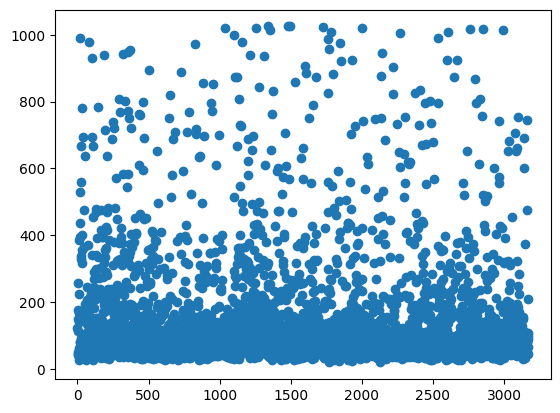

In [46]:
plt.scatter(np.arange(len(arr)), arr)
# plt.yscale('log')

  0%|          | 0/3851 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


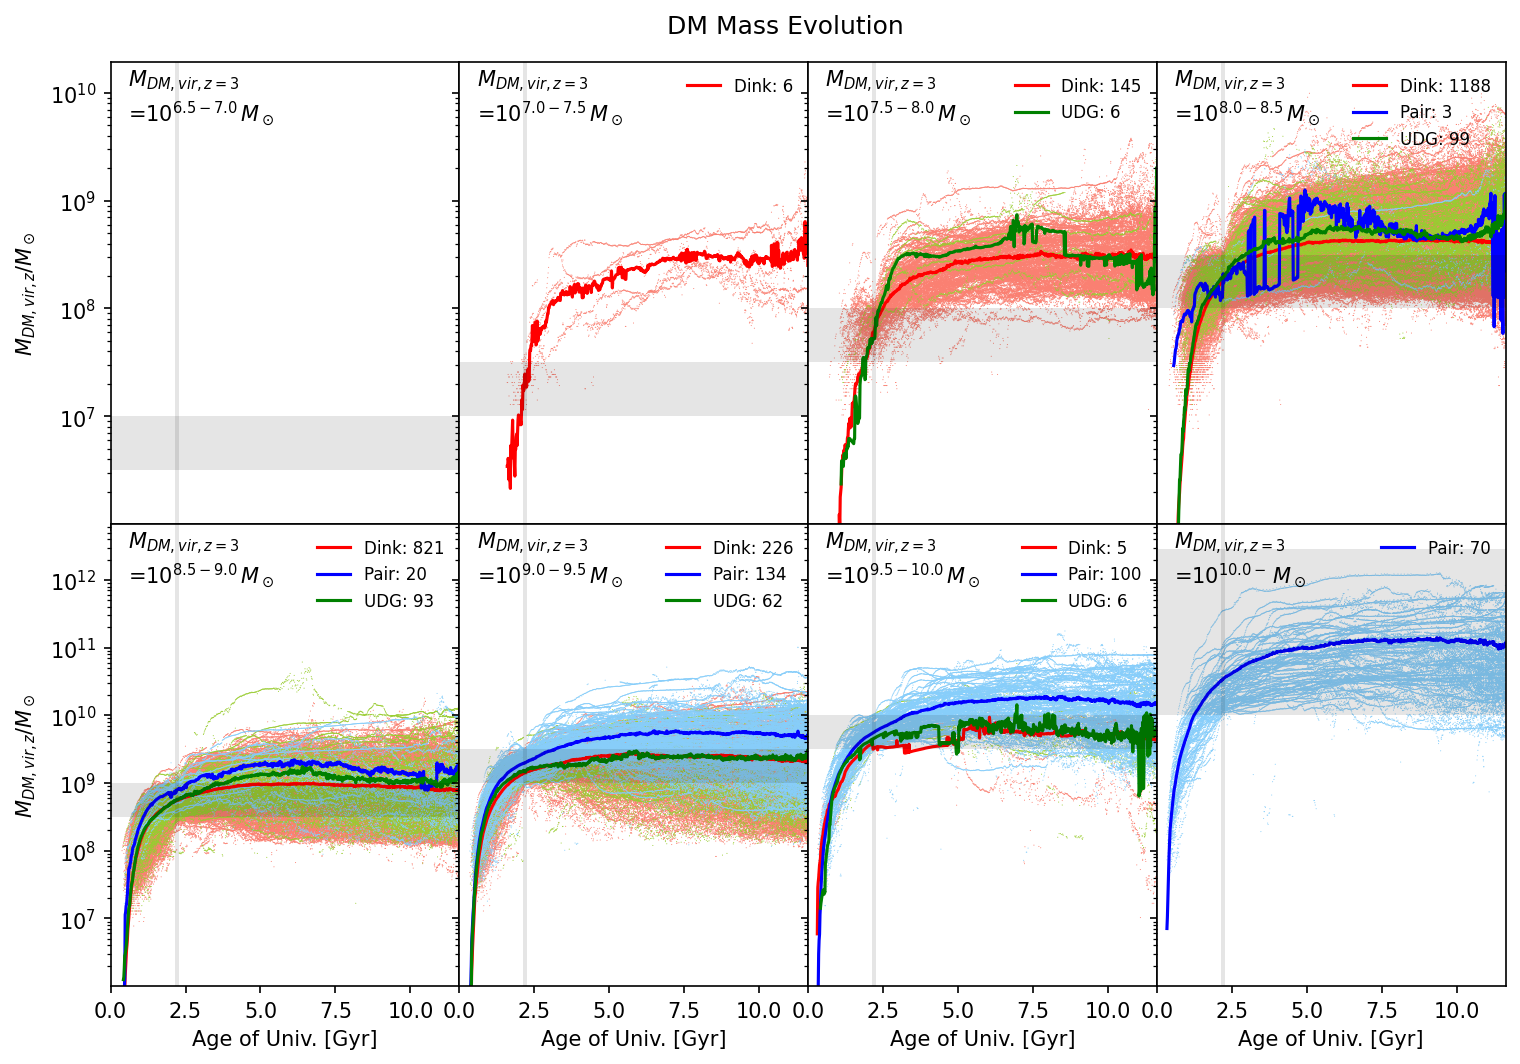

ValueError: stop!

In [33]:
##### Change These #####
binval = 'mvir' 
binname = fr"$M_{{DM,vir,z=3}}$"
mmin=6.5; mmax=10.5
mbins = np.arange(mmin, mmax, 0.5)

vals = ['mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', ('mstar_vir','mcell_vir')]
valnames = [fr"$M_{{DM,vir,z}}$", fr"$M_{{*,vir,z}}$", fr"$M_{{Gas,vir,z}}$", fr"$M_{{Cold,vir,z}}$", fr"$M_{{Bary,vir,z}}$"]
titles = ["DM Mass Evolution", "Stellar Mass Evolution", "Gas Mass Evolution", "Cold Gas Mass Evolution", "Baryon Mass Evolution"]
fnames = ['dm', 'star', 'gas', 'cold', 'baryon']
ymins = [1e6 + 1, 1e4 + 1, 1e5 + 1, 1e4 + 1, 1e5 + 1]
########################

def getval(table, args):
    y = 0
    if(type(args) is str): return table[args]
    elif(type(args) is tuple):
        for arg in args:
            y += table[arg]
        return y
    else:
        raise ValueError("args must be str or tuple")



for val,valname,title,ymin,fname in zip(vals,valnames,titles,ymins,fnames):
    if(os.path.exists(f"{database}/photo/06_evolution/Massevol_{fname}_z3bin_gyr.png")): continue
    fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
    plt.subplots_adjust(wspace=0, hspace=0)
    for ax in axes.flatten():
        ax.set_yscale('log')



    results = {}
    for iax in range(8):
        results[iax] = {}
        for name in names:
            results[iax][name] = np.zeros(1027)
    for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
        color = scolors[state]
        tmp = reduced_tree[sub['id']]
        tmp = tmp[tmp['take_score'] > 0.1]
        zorder = zorders[state]
        y = getval(tmp, val)
        where = isin(tmp['timestep'], involed_outs)
        if(np.sum(where)==0): continue
        mass_at_z3 = np.mean(tmp[where][binval])
        if(mass_at_z3 < 10**mmin): continue
        iax = np.searchsorted(mbins, np.log10(mass_at_z3))-1
        ax = axes.flatten()[iax]
        ax.scatter(out2gyr(tmp['timestep']), y, ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)
        # ax.plot(tmp['timestep'], y, color=color, lw=0.25, alpha=1, zorder=zorder)

        results[iax][state][tmp['timestep']] += y
        results[iax][state][0] += 1

    # label1s = [fr"{binname}=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"{binname}>$10^{{11}}\,M_\odot$"]
    labels = [fr"=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"=$10^{{{mmax-0.5}-}}\,M_\odot$"]
    legends = ['Dink','Pair','UDG']
    for iax in range(8):
        result = results[iax]
        ax = axes.flatten()[iax]
        ax.text(0.05, 0.96, binname, ha='left', va='center', transform=ax.transAxes)
        ax.text(0.05, 0.89, labels[iax], ha='left', va='center', transform=ax.transAxes)
        if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none', fc='k', alpha=0.1, zorder=10)
        else:ax.axhspan(10**mbins[iax], ax.get_ylim()[1], ec='none', fc='k', alpha=0.1, zorder=10)
        ax.axvspan(agemin, agemax, ec='none', fc='k', alpha=0.1, zorder=10)
        for legend,name in zip(legends,names):
            tmp = result[name]
            count = tmp[0]; tmp=tmp[1:]
            if(count>0):
                x = np.where(tmp>0)[0]
                y = tmp[x]/count
                ax.plot(out2gyr(x+1),y, color=colors[name], label=f"{legend}: {int(count)}")
        ax.legend(loc='upper right', frameon=False, fontsize=8)

    for i in range(2):
        axes[i,0].set_ylabel(fr"{valname}$/M_\odot$")
        axes[i,0].set_ylim(ymin,)

    for i in range(4):
        axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")
        axes[1,i].set_xlim(0,11.63)

    fig.suptitle(title, y=0.92)
    # plt.savefig(f"{database}/photo/06_evolution/Massevol_{fname}_z3bin_gyr.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    stop()

In [20]:
stop()

ValueError: stop!

# Initial DM Mass Binning

## Mass Evolution

In [43]:
tmp['take_score']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

  0%|          | 0/3851 [00:00<?, ?it/s]

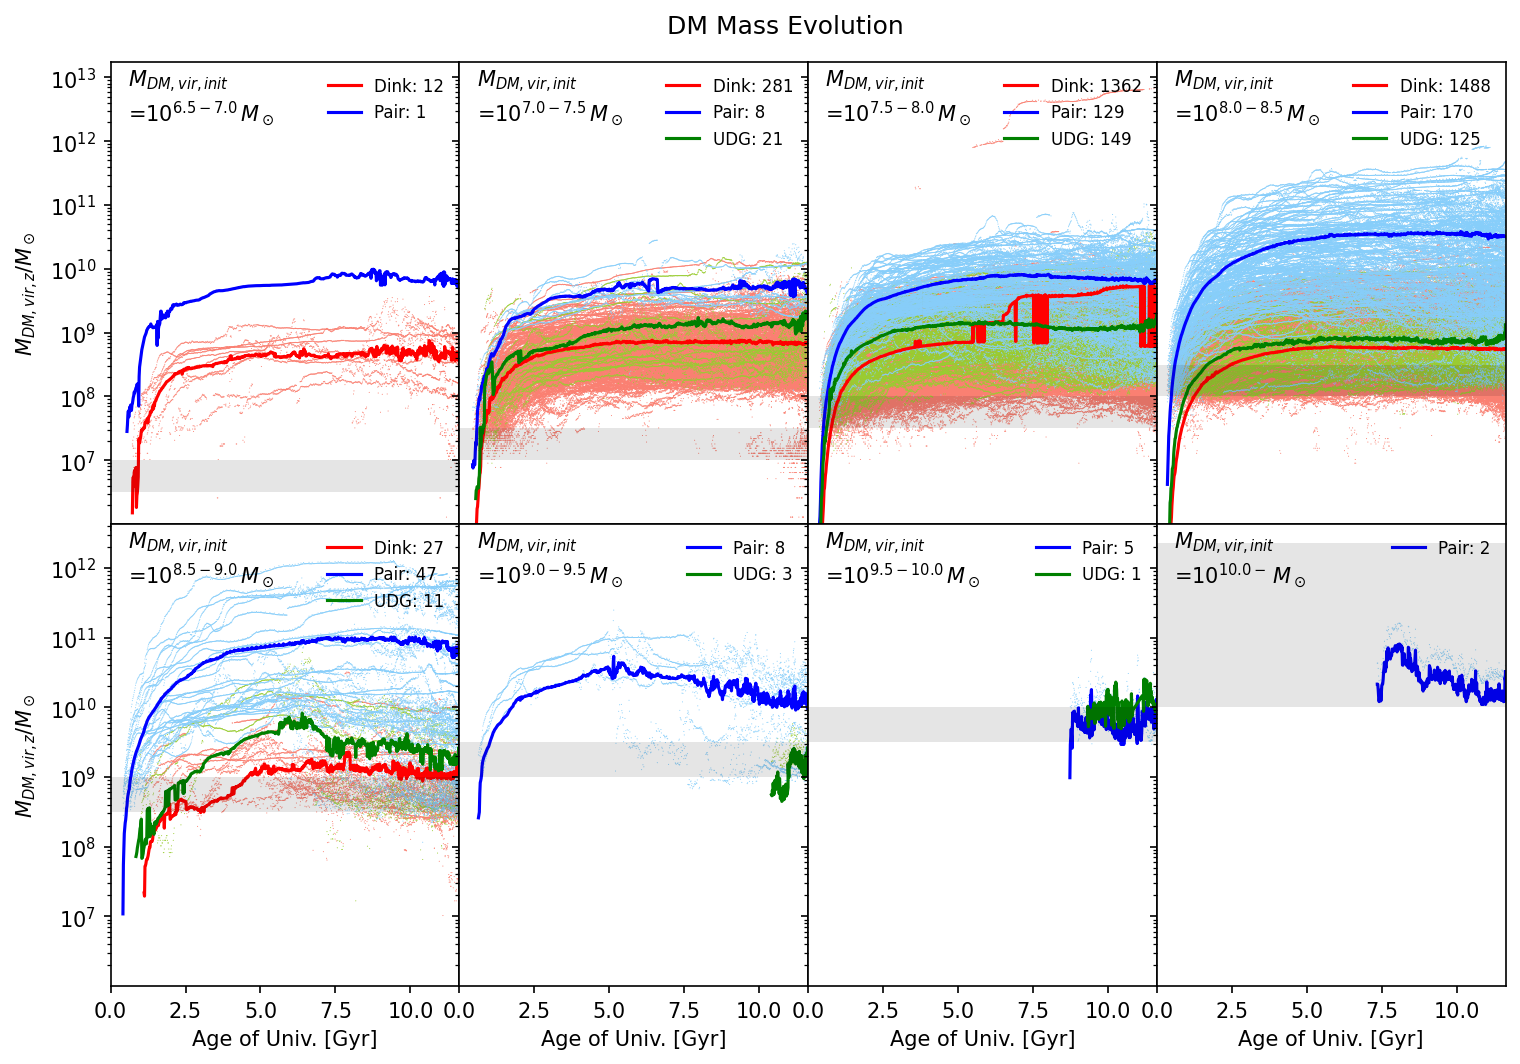

ValueError: stop!

In [50]:
##### Change These #####
binval = 'mvir' 
binname = fr"$M_{{DM,vir,init}}$"
mmin=6.5; mmax=10.5
mbins = np.arange(mmin, mmax, 0.5)

vals = ['mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', ('mstar_vir','mcell_vir')]
valnames = [fr"$M_{{DM,vir,z}}$", fr"$M_{{*,vir,z}}$", fr"$M_{{Gas,vir,z}}$", fr"$M_{{Cold,vir,z}}$", fr"$M_{{Bary,vir,z}}$"]
titles = ["DM Mass Evolution", "Stellar Mass Evolution", "Gas Mass Evolution", "Cold Gas Mass Evolution", "Baryon Mass Evolution"]
fnames = ['dm', 'star', 'gas', 'cold', 'baryon']
ymins = [1e6 + 1, 1e4 + 1, 1e5 + 1, 1e4 + 1, 1e5 + 1]
########################

def getval(table, args):
    y = 0
    if(type(args) is str): return table[args]
    elif(type(args) is tuple):
        for arg in args:
            y += table[arg]
        return y
    else:
        raise ValueError("args must be str or tuple")



for val,valname,title,ymin,fname in zip(vals,valnames,titles,ymins,fnames):
    if(os.path.exists(f"{database}/photo/06_evolution/Massevol_{fname}_initbin_gyr.png")): continue
    fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
    plt.subplots_adjust(wspace=0, hspace=0)
    for ax in axes.flatten():
        ax.set_yscale('log')



    results = {}
    for iax in range(8):
        results[iax] = {}
        for name in names:
            results[iax][name] = np.zeros(1027)
    for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
        color = scolors[state]
        tmp = reduced_tree[sub['id']]
        # tmp = tmp[tmp['take_score'] > 0.1]
        zorder = zorders[state]
        where = tmp['take_score'] > 0.5
        if(np.sum(where)==0): continue
        mass_at_z3 = np.mean(tmp[where][-1][binval])
        if(mass_at_z3 < 10**mmin): continue
        mask = tmp['timestep'] > tmp[where][-1]['timestep']
        tmp = tmp[mask]
        y = getval(tmp, val)
        iax = np.searchsorted(mbins, np.log10(mass_at_z3))-1
        ax = axes.flatten()[iax]
        ax.scatter(out2gyr(tmp['timestep']), y, ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)
        # ax.plot(tmp['timestep'], y, color=color, lw=0.25, alpha=1, zorder=zorder)

        results[iax][state][tmp['timestep']] += y
        results[iax][state][0] += 1

    # label1s = [fr"{binname}=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"{binname}>$10^{{11}}\,M_\odot$"]
    labels = [fr"=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [fr"=$10^{{{mmax-0.5}-}}\,M_\odot$"]
    legends = ['Dink','Pair','UDG']
    for iax in range(8):
        result = results[iax]
        ax = axes.flatten()[iax]
        ax.text(0.05, 0.96, binname, ha='left', va='center', transform=ax.transAxes)
        ax.text(0.05, 0.89, labels[iax], ha='left', va='center', transform=ax.transAxes)
        if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none', fc='k', alpha=0.1, zorder=10)
        else:ax.axhspan(10**mbins[iax], ax.get_ylim()[1], ec='none', fc='k', alpha=0.1, zorder=10)
        # ax.axvspan(agemin, agemax, ec='none', fc='k', alpha=0.1, zorder=10)
        for legend,name in zip(legends,names):
            tmp = result[name]
            count = tmp[0]; tmp=tmp[1:]
            if(count>0):
                x = np.where(tmp>0)[0]
                y = tmp[x]/count
                ax.plot(out2gyr(x+1),y, color=colors[name], label=f"{legend}: {int(count)}")
        ax.legend(loc='upper right', frameon=False, fontsize=8)

    for i in range(2):
        axes[i,0].set_ylabel(fr"{valname}$/M_\odot$")
        axes[i,0].set_ylim(ymin,)

    for i in range(4):
        axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")
        axes[1,i].set_xlim(0,11.63)

    fig.suptitle(title, y=0.92)
    # plt.savefig(f"{database}/photo/06_evolution/Massevol_{fname}_initbin_gyr.png", dpi=400, transparent=False, facecolor='w', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    stop()

# Find Same Assembly History

  0%|          | 0/3851 [00:00<?, ?it/s]

  0%|          | 0/3851 [00:00<?, ?it/s]

1010.0 997.0 948.0
257.0 257.0 257.0
44.0 44.0 55.0
84.0 84.0 175.0
50.0 50.0 53.0
150.0 150.0 183.0
41.0 41.0 41.0
120.0 120.0 122.0
62.0 62.0 62.0
168.0 168.0 168.0
140.0 140.0 140.0
26.0 26.0 26.0
985 [25169]


ValueError: stop!

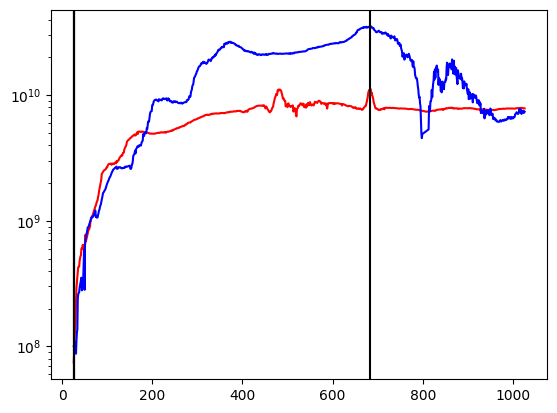

In [62]:
t10s = np.zeros(len(allsubs))
t50s = np.zeros(len(allsubs))
t90s = np.zeros(len(allsubs))
tpeaks = np.zeros(len(allsubs))

ith = 0
for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
    color = scolors[state]
    tmp = reduced_tree[sub['id']]
    lastm = tmp[-1]['mvir']
    argmin = np.argmin(np.abs(tmp['mvir'] - lastm*0.1))
    t10s[ith] = tmp[argmin]['timestep']
    argmin = np.argmin(np.abs(tmp['mvir'] - lastm*0.5))
    t50s[ith] = tmp[argmin]['timestep']
    argmin = np.argmin(np.abs(tmp['mvir'] - lastm*0.9))
    t90s[ith] = tmp[argmin]['timestep']
    argmax = np.argmax(tmp['mvir'])
    tpeaks[ith] = tmp[argmax]['timestep']

    ith+=1

ith = 0
for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
    if(state != 'dink'):
        ith += 1
        continue
    t10,t50,t90,tpeak = t10s[ith],t50s[ith],t90s[ith], tpeaks[ith]
    print(t10, t50, t90)
    tmp = reduced_tree[sub['id']]

    mask1 = states == 'pair'
    mask2 = (allsubs['mvir'] >= 0.9*sub['mvir'])&(allsubs['mvir'] <= 1.1*sub['mvir'])
    mask = mask1 & mask2
    if(np.sum(mask)==0):
        ith += 1
        continue
    mask3 = (t10s >= t10-10)&(t10s <= t10+10)
    mask4 = (t50s >= t50-10)&(t50s <= t50+10)
    mask5 = (t90s >= t90-10)&(t90s <= t90+10)
    mask6 = (tpeaks >= tpeak-10)&(tpeaks <= tpeak+10)
    mask = mask1 & mask2 & mask3 & mask4 & mask5 & mask6
    if(np.sum(mask)==0):
        ith += 1
        continue
    counters = allsubs[mask]
    print(sub['id'], counters['id'])

    fig, ax = plt.subplots()
    ax.plot(tmp['timestep'], tmp['mvir'], color='r')
    for counter in counters:
        tmp = reduced_tree[counter['id']]
        ax.plot(tmp['timestep'], tmp['mvir'], color='b')

    ax.axvline(t10, color='k')
    ax.axvline(t50, color='k')
    ax.axvline(t90, color='k')
    ax.axvline(tpeak, color='k')
    ax.set_yscale('log')
    ith += 1
    stop()
    

## Star Mass

Final Mass Binning

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
plt.subplots_adjust(wspace=0, hspace=0)
for ax in axes.flatten():
    ax.set_yscale('log')
count = 0

val = 'mstar_vir'
mmin = 6.5
mbins = np.arange(mmin, 10.5, 0.5)
results = {}
for iax in range(8):
    results[iax] = {}
    for name in names:
        results[iax][name] = np.zeros(1027)
for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
    if(sub[val] < 10**mmin): continue
    iax = np.searchsorted(mbins, np.log10(sub[val]))-1
    ax = axes.flatten()[iax]
    color = scolors[state]
    tmp = reduced_tree[sub['id']]#trees[trees['lastid'] == sub['id']]
    tmp = tmp[tmp['take_score'] > 0.1]
    zorder = zorders[state]
    ax.scatter(tmp['timestep'], tmp[val], ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)

    # results[state][tmp['timestep']] = results[state][tmp['timestep']] + tmp[val]
    results[iax][state][tmp['timestep']] += tmp[val]
    results[iax][state][0] += 1

    count += 1

    # if(count>500): break

labels = [f"$M_{{*,vir}}$=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [r"$M_{*,vir}$>$10^{11}\,M_\odot$"]
titles = ['Dink','Pair','UDG']
for iax in range(8):
    result = results[iax]
    ax = axes.flatten()[iax]
    ax.text(0.05, 0.95, labels[iax], ha='left', va='center', transform=ax.transAxes)
    if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none',fc='k', alpha=0.1, zorder=-1)
    else:ax.axhspan(10**mbins[iax], 10**12, ec='none',fc='k', alpha=0.1, zorder=-1)
    for title,name in zip(titles,names):
        tmp = result[name]
        count = tmp[0]; tmp=tmp[1:]
        if(count>0):
            x = np.where(tmp>0)[0]
            y = tmp[x]/count
            ax.plot(x,y, color=colors[name], label=f"{title}: {int(count)}")
    ax.legend(loc='lower right', frameon=False)

for i in range(2):
    axes[i,0].set_ylabel(r"$M_{*,vir}/M_\odot$")
    axes[i,0].set_ylim(1e4,)

for i in range(4):
    axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")


plt.show()

Peak Mass Binning

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8), dpi=150, sharex='col', sharey='row')
plt.subplots_adjust(wspace=0, hspace=0)
for ax in axes.flatten():
    ax.set_yscale('log')
count = 0

val = 'mstar_vir'
mmin = 6.5
mbins = np.arange(mmin, 10.5, 0.5)
results = {}
for iax in range(8):
    results[iax] = {}
    for name in names:
        results[iax][name] = np.zeros(1027)
for sub, state in tqdm( zip(allsubs, states), total=len(allsubs) ):
    tmp = reduced_tree[sub['id']]#trees[trees['lastid'] == sub['id']]
    tmp = tmp[tmp['take_score'] > 0.1]
    maxm = np.max( np.log10(tmp[val]) )
    if(maxm < mmin): continue
    iax = np.searchsorted(mbins, maxm)-1
    ax = axes.flatten()[iax]
    color = scolors[state]
    zorder = zorders[state]
    ax.scatter(tmp['timestep'], tmp[val], ec='none', fc=color, s=0.25, alpha=1, zorder=zorder)

    # results[state][tmp['timestep']] = results[state][tmp['timestep']] + tmp[val]
    results[iax][state][tmp['timestep']] += tmp[val]
    results[iax][state][0] += 1

    count += 1

    # if(count>500): break

labels = [f"$M_{{*,Peak}}$=$10^{{{mbins[i]}-{mbins[i+1]}}}\,M_\odot$" for i in range(7)] + [r"$M_{*,Peak}$>$10^{11}\,M_\odot$"]
titles = ['Dink','Pair','UDG']
for iax in range(8):
    result = results[iax]
    ax = axes.flatten()[iax]
    ax.text(0.05, 0.95, labels[iax], ha='left', va='center', transform=ax.transAxes)
    if(iax<7): ax.axhspan(10**mbins[iax], 10**mbins[iax+1], ec='none',fc='k', alpha=0.1, zorder=-1)
    else:ax.axhspan(10**mbins[iax], 10**12, ec='none',fc='k', alpha=0.1, zorder=-1)
    for title,name in zip(titles,names):
        tmp = result[name]
        count = tmp[0]; tmp=tmp[1:]
        if(count>0):
            x = np.where(tmp>0)[0]
            y = tmp[x]/count
            ax.plot(x,y, color=colors[name], label=f"{title}: {int(count)}")
    ax.legend(loc='lower right', frameon=False)

for i in range(2):
    axes[i,0].set_ylabel(r"$M_{*,Peak}/M_\odot$")
    axes[i,0].set_ylim(1e4,)

for i in range(4):
    axes[1,i].set_xlabel(r"Age of Univ. [Gyr]")


plt.show()